**Interpretable Flow Feature Extracion Via Neuron Guided Sparse Latent Convolutional Autoencoder**

**Authors:** Md. Kamrul Islam (RUET,Bangladesh), Mansuba Tabassum (ULAB, Bangladesh), Mim Mashrur Ahmed (RUET, Bangladesh), and Mahadi Hasan Masud (RUET,   Bangladesh)

Note: The paper is currently in the submission process and does not yet have a formal citation.

We provide no guarantees for this code. Use as-is for academic research purposes only; no commercial use is allowed without permission.

-- version 1: Sep 18, 2025

For performing the code, the user has to install, ‘keras, tensorflow, numpy, pandas, scikit-learn, matplotlib, tqdm, pickle’.

**References**

[1] Data Source: Murata, T.; Fukami, K.; Fukagata, K. Nonlinear Mode Decomposition with Convolutional Neural Networks for Fluid Dynamics. J. Fluid Mech. 2020, 882, A13, 575 doi:10.1017/jfm.2019.822.

**Links**

Data Source: The dataset utilized in this resesrch can be found here:(https://keio.app.box.com/s/dt6ggwshe4v7ny5bjkf4ut4hnygzla58)

**Mount Google Drive**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Lambda
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle
from tqdm import tqdm as tqdm
import os, sys
# Ensure reproducibility
np.random.seed(0)
tf.random.set_seed(0)

**Load Flow Field Data**

In [ ]:
# Data stored in pickle format: (#snapshots, 384 (Nx), 192 (Ny), 2 (u, v))
X=[]
for i in tqdm(range(1)):
    fnstr="/content/drive/MyDrive/data/flow_field_data0.pickle"
    # Pickle load
    with open(fnstr, 'rb') as f:
        obj = pickle.load(f)
    if i==0:
        X=obj
    else:
        X=np.concatenate([X,obj],axis=0)
print(X.shape)

100%|██████████| 1/1 [00:08<00:00,  8.88s/it]

(2000, 384, 192, 2)


**Load and Process Mean Velocity Field**

In [ ]:
# mean field stored in mode0.csv
mode0=pd.read_csv("/content/drive/MyDrive/data/mode0.csv", header=None, delim_whitespace=None)
mode0=mode0.values

x_num0=384; y_num0=192;
Uf0=mode0[0:x_num0*y_num0]
Vf0=mode0[x_num0*y_num0:x_num0*y_num0*2]
Uf0=np.reshape(Uf0,[x_num0,y_num0])
Vf0=np.reshape(Vf0,[x_num0,y_num0])

# Subtract mean field from dataset to obtain fluctuations
for i in range(len(X)):
    X[i,:,:,0]=X[i,:,:,0]-Uf0
    X[i,:,:,1]=X[i,:,:,1]-Vf0

/tmp/ipython-input-3298096389.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mode0=pd.read_csv("/content/drive/MyDrive/data/mode0.csv", header=None, delim_whitespace=None)


**Prepare mean velocity field for reconstruction**

In [ ]:
# Stack along the last axis to get shape (384, 192, 2)
UV_stack = np.stack((Uf0, Vf0), axis=-1)

# Add batch dimension at the beginning to get (1, 384, 192, 2)
UV_reshaped = UV_stack[np.newaxis, ...]

print(UV_reshaped.shape)

(1, 384, 192, 2)


**Visualize Velocity Magnitude for a Snapshot**

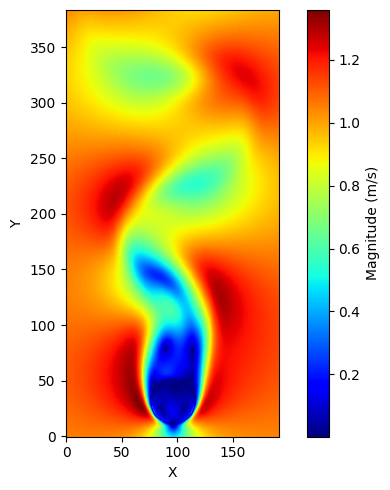

In [ ]:
snapshot = 0  # index of snapshot
u = X[snapshot, :, :, 0]+UV_reshaped[0, :, :, 0]
v = X[snapshot, :, :, 1]+UV_reshaped[0, :, :, 1]
velocity_magnitude = np.sqrt(u**2 + v**2)
plt.figure(figsize=(6,5))
plt.imshow(velocity_magnitude, cmap='jet', origin='lower')
plt.colorbar(label='Magnitude (m/s)')
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

**Build Dense CNN Autoencoder**

In [ ]:
act = 'tanh'
input_img = Input(shape=(384,192,2))

#Encoder
x = Conv2D(16, (3,3), activation=act, padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation=act, padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation=act, padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation=act, padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(4, (3,3), activation=act, padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(4, (3,3), activation=act, padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Reshape([6*3*4])(x)
encoded_latent = Dense(72, activation=act, name='latent_dense')(x)

#Decoder
x = Dense(72, activation=act)(encoded_latent)
x = Reshape([6,3,4])(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(4, (3,3), activation=act, padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation=act, padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation=act, padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation=act, padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation=act, padding='same')(x)
x = UpSampling2D((2,2))(x)
output_img = Conv2D(2, (3,3), activation='linear', padding='same')(x)

# Compile model
dense_ae = Model(input_img, output_img)
encoder_dense = Model(input_img, encoded_latent)
decoder_dense = Model(encoded_latent, output_img)
dense_ae.compile(optimizer='adam', loss='mse')

**Train the Autoencoder**

In [ ]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth enabled")
    except RuntimeError as e:
        print(e)


# Split dataset
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)

# Train with validation
with tf.device('/GPU:0'):
    dense_ae.fit(X_train, X_train, epochs=30, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical devices cannot be modified after being initialized
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - loss: 0.0292 - val_loss: 0.0092
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0070 - val_loss: 0.0036
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0012 - val_loss: 0.0011
Epoc

**Threshold-based Neuron Analysis (Neuron activation bar charts + segmented analysis)**

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


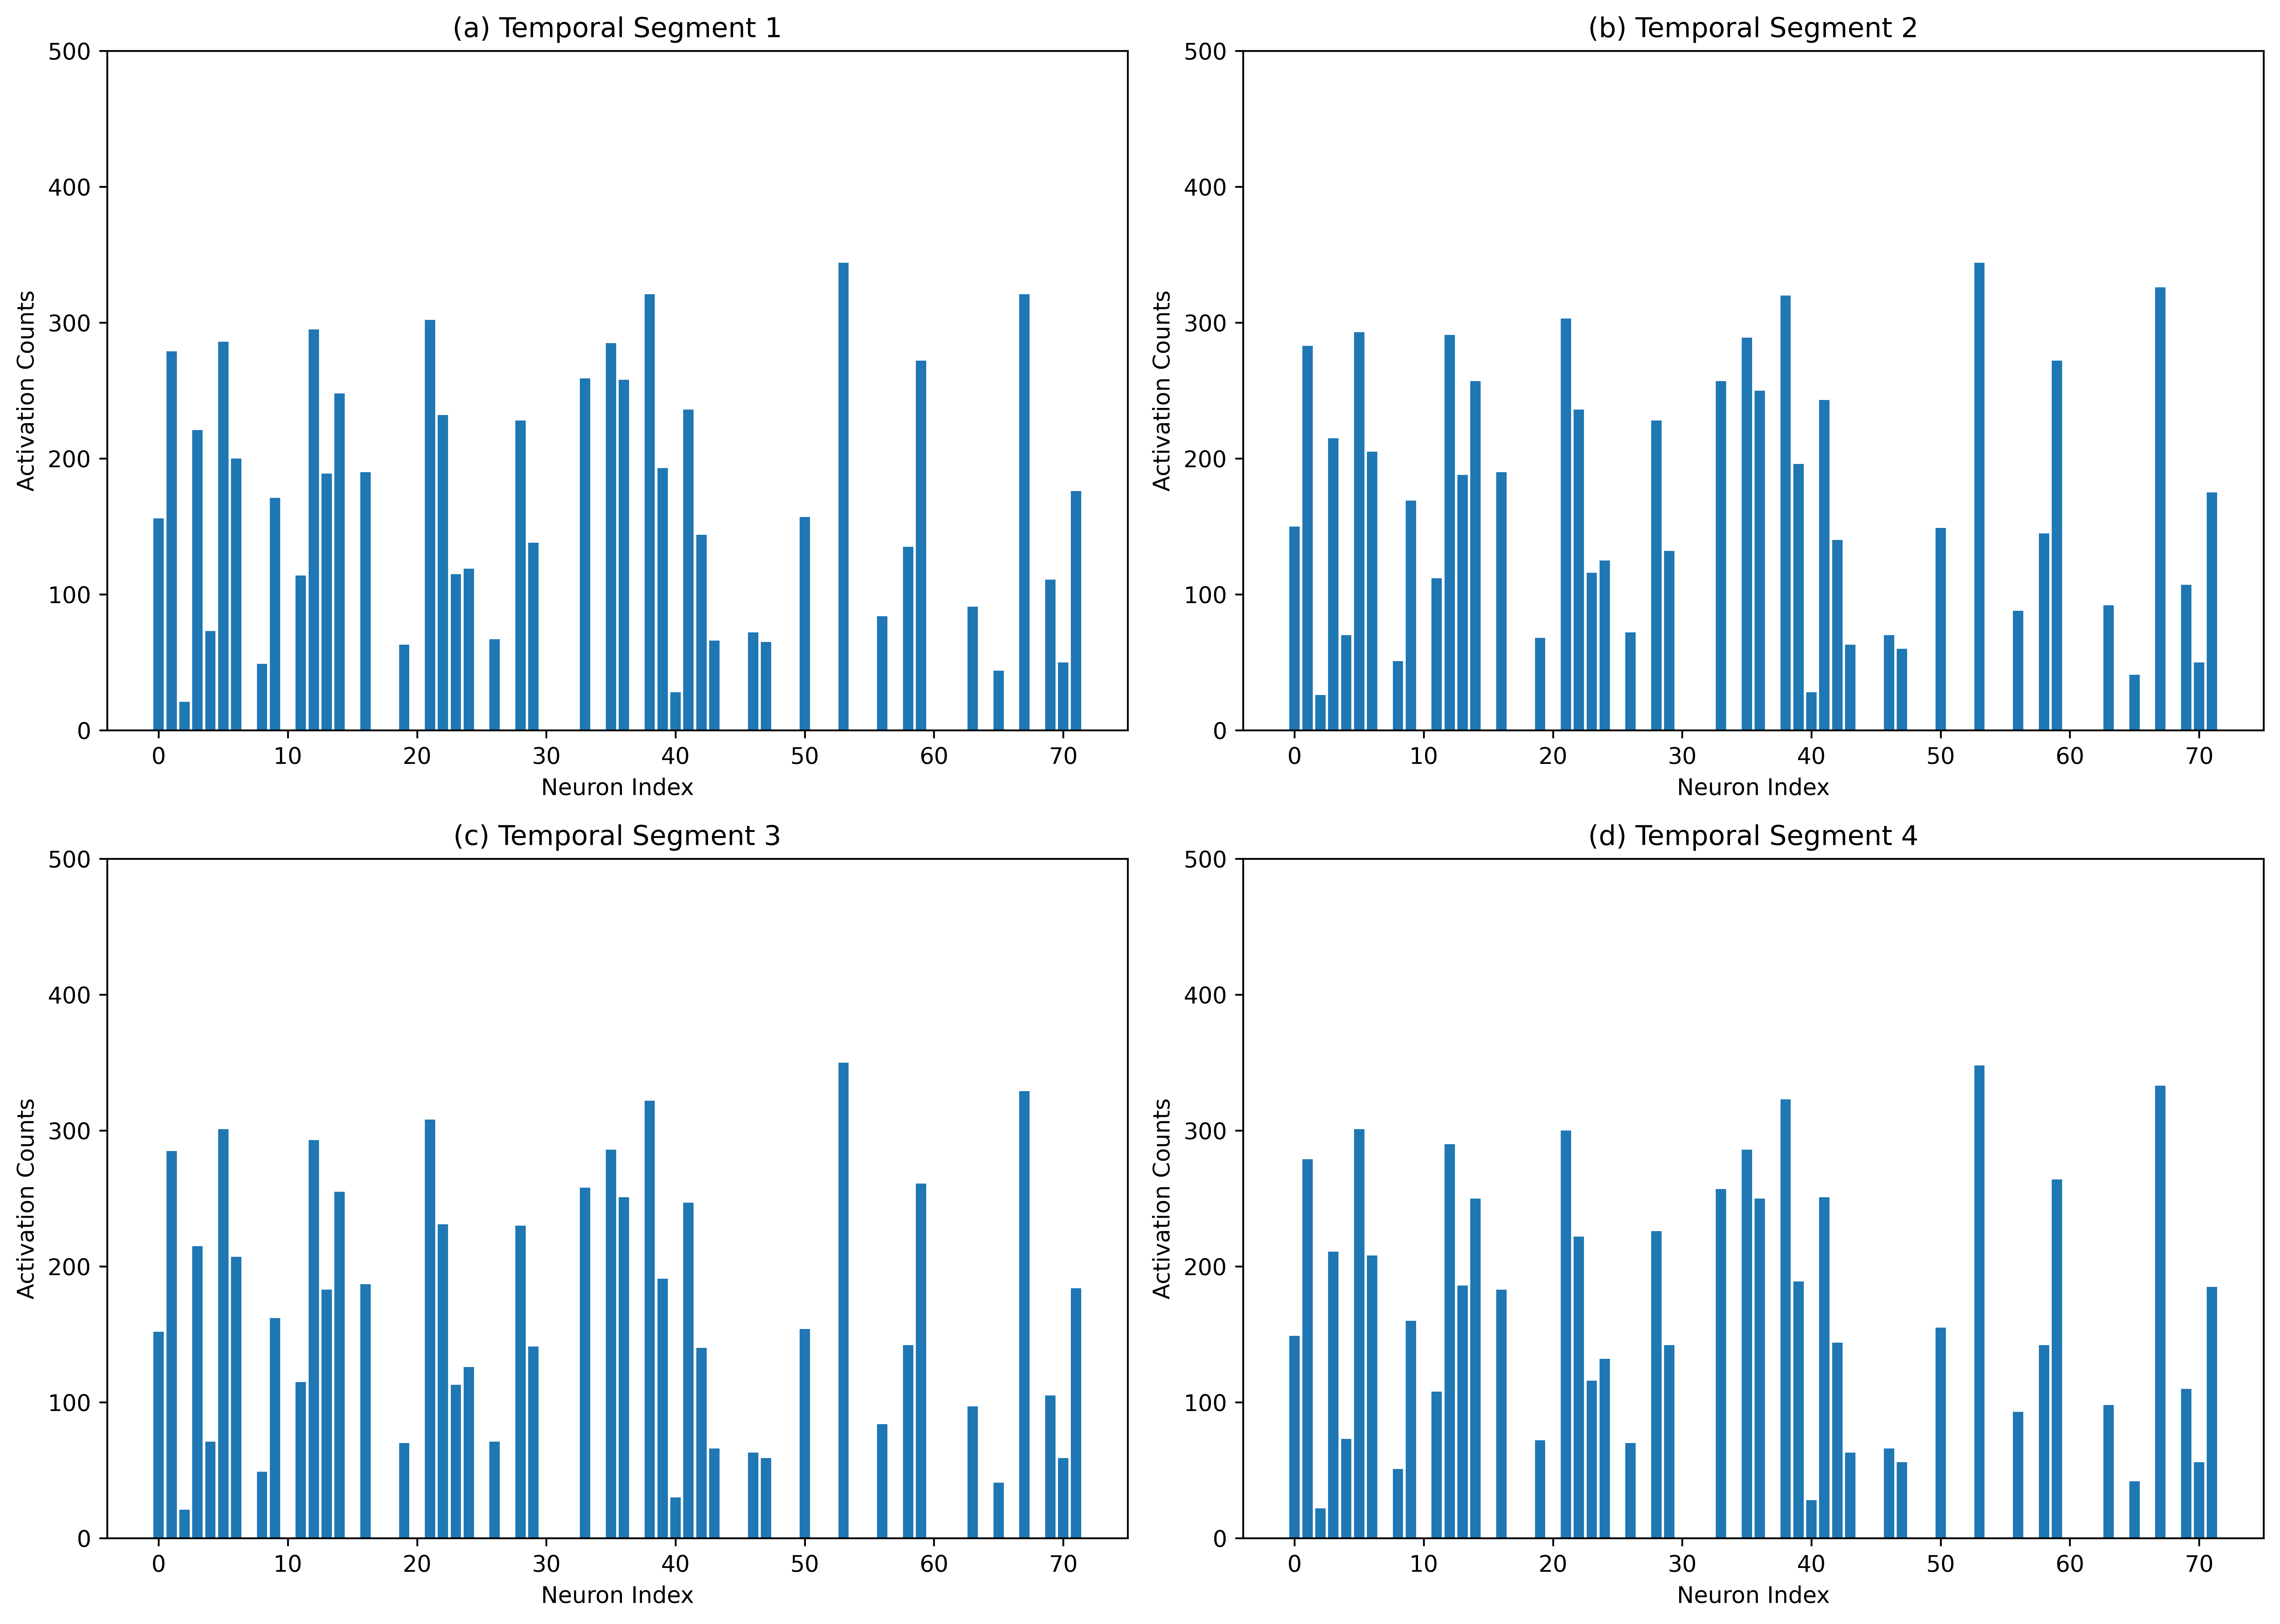

<Figure size 3840x2880 with 0 Axes>

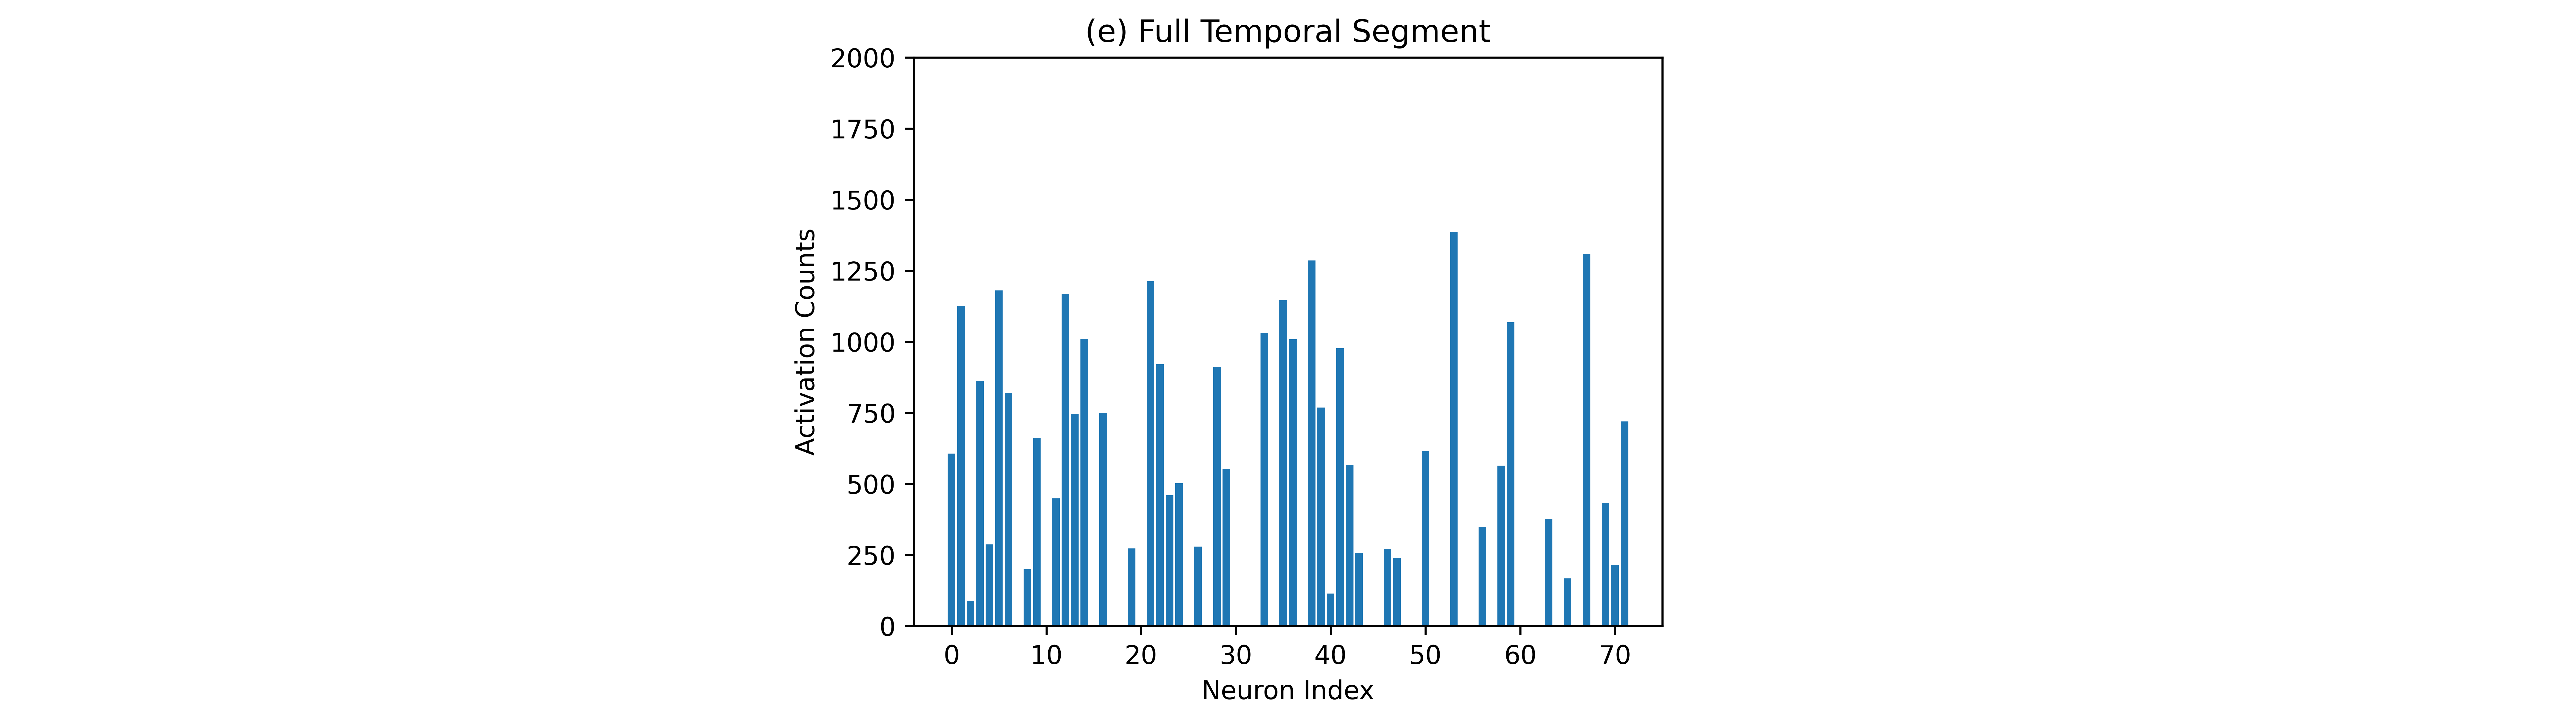

In [ ]:
#Encode full dataset
latent_output = encoder_dense.predict(X)  # shape (n_snapshots, 72)
threshold = 0.1
#Split into 4 temporal segments
segments = np.array_split(latent_output, 4)

#Plot threshold activation counts for each segment
plt.figure(figsize=(14, 10))
for i, segment in enumerate(segments):
    binary_activation = np.abs(segment) > threshold
    activation_count = np.sum(binary_activation, axis=0)
    plt.subplot(2, 2, i+1)
    plt.bar(np.arange(len(activation_count)), activation_count)
    plt.title(f"({chr(97+i)}) Temporal Segment {i+1}")
    plt.xlabel("Neuron Index")
    plt.ylabel("Activation Counts")
    plt.ylim(0, segment.shape[0])
plt.tight_layout()
plt.show()

#Plot for full dataset
binary_activation_full = np.abs(latent_output) > threshold
activation_count_full = np.sum(binary_activation_full, axis=0)
# Use a 1x3 grid and plot in the center (position 2)
fig, axes = plt.subplots(1, 3, figsize=(14,4))
axes[0].axis('off')  # left empty
axes[2].axis('off')  # right empty
axes[1].bar(np.arange(len(activation_count_full)), activation_count_full)
axes[1].set_title("(e) Full Temporal Segment")
axes[1].set_xlabel("Neuron Index")
axes[1].set_ylabel("Activation Counts")
axes[1].set_ylim(0, latent_output.shape[0])
plt.tight_layout()
plt.show()

**Threshold based Sparsity–Reconstruction Error Trade-off Curve**

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


  0%|          | 0/19 [00:00<?, ?it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


  5%|▌         | 1/19 [00:29<08:43, 29.06s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


 11%|█         | 2/19 [00:57<08:02, 28.41s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


 16%|█▌        | 3/19 [01:22<07:13, 27.09s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


 21%|██        | 4/19 [01:49<06:46, 27.08s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


 26%|██▋       | 5/19 [02:16<06:17, 26.97s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


 32%|███▏      | 6/19 [02:44<05:57, 27.51s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


 37%|███▋      | 7/19 [03:11<05:25, 27.10s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


 42%|████▏     | 8/19 [03:35<04:48, 26.22s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


 47%|████▋     | 9/19 [04:02<04:23, 26.35s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


 53%|█████▎    | 10/19 [04:28<03:57, 26.34s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


 58%|█████▊    | 11/19 [04:54<03:30, 26.33s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


 63%|██████▎   | 12/19 [05:19<03:00, 25.75s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


 68%|██████▊   | 13/19 [05:47<02:39, 26.66s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


 74%|███████▎  | 14/19 [06:13<02:11, 26.25s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


 79%|███████▉  | 15/19 [06:39<01:45, 26.37s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


 84%|████████▍ | 16/19 [07:07<01:20, 26.74s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


 89%|████████▉ | 17/19 [07:35<00:54, 27.02s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


 95%|█████████▍| 18/19 [08:00<00:26, 26.45s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


100%|██████████| 19/19 [08:27<00:00, 26.74s/it]


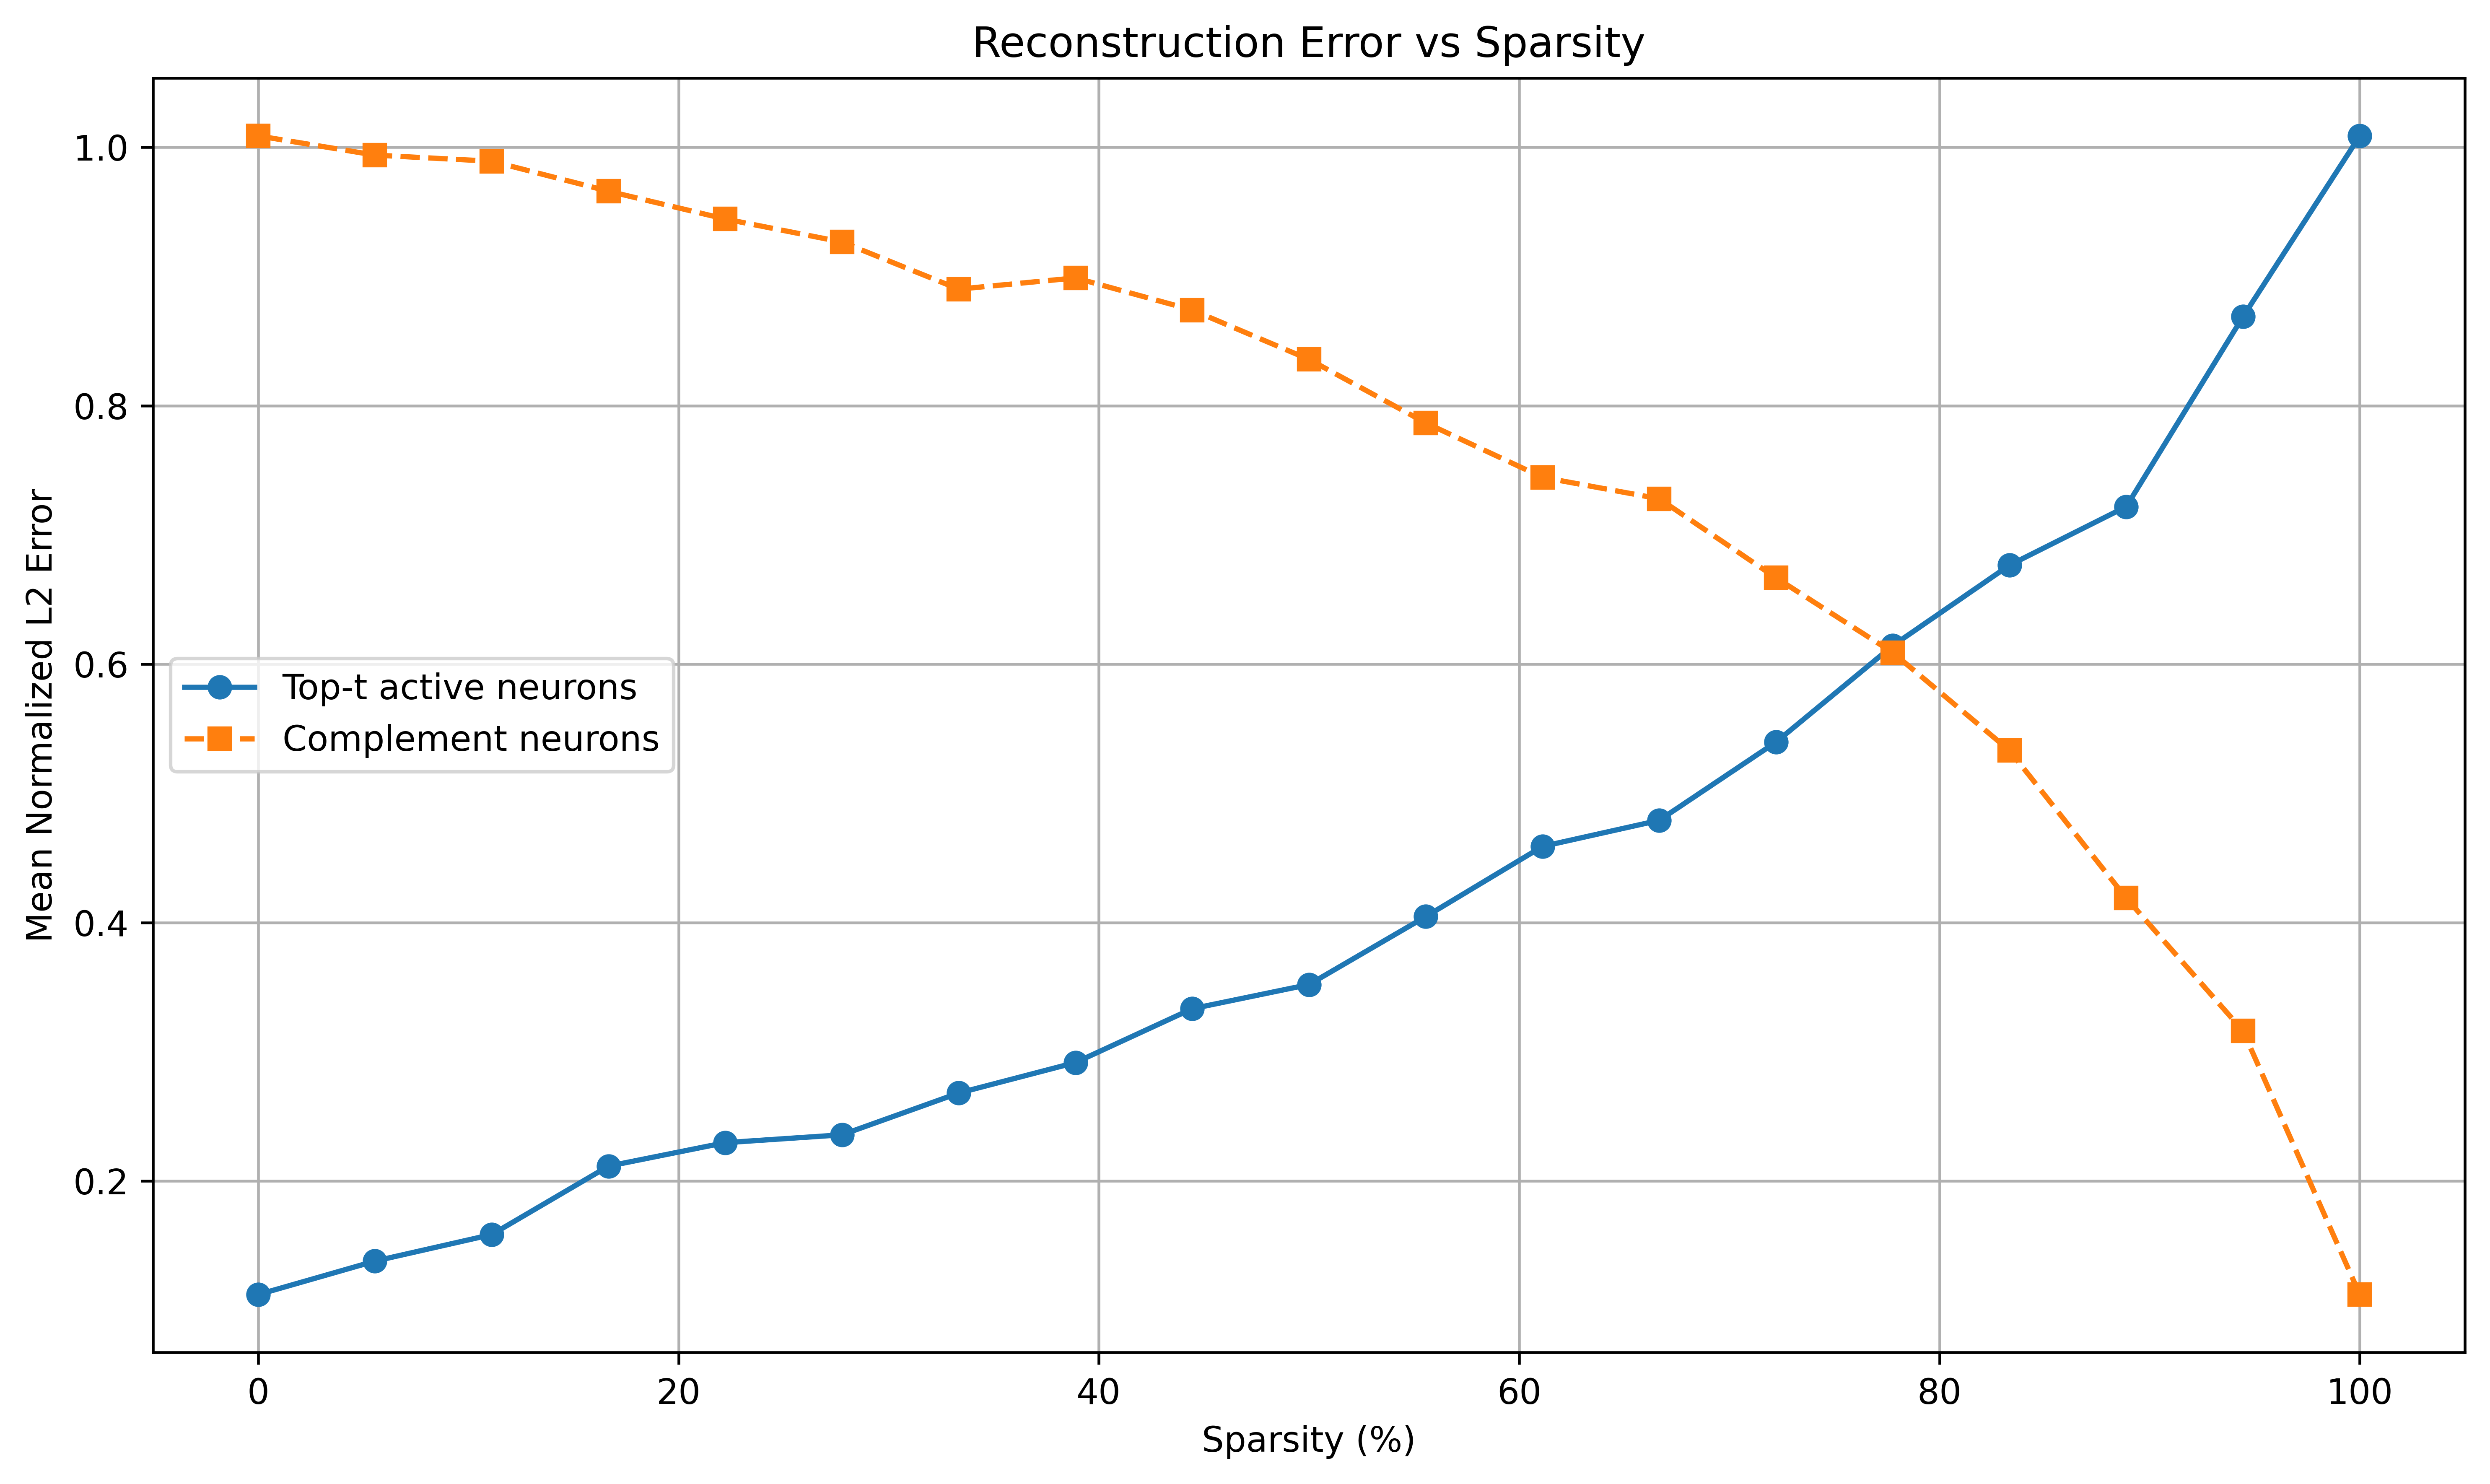

In [ ]:
#Compute activation counts for each neuron
activation_threshold = 0.1
latent_output = encoder_dense.predict(X)
neuron_activity = np.abs(latent_output) > activation_threshold
activation_counts = np.sum(neuron_activity, axis=0)  # shape: (72,)

# Prepare for loop
latent_dim = latent_output.shape[1]
step = 4
sparsity_list = []
top_n_errors = []
suppressed_n_errors = []

#Loop from n=0 to 72 in increments of 4
for n in tqdm(range(0, latent_dim + 1, step)):
    #Get top-n active neurons
    top_n_indices = np.argsort(-activation_counts)[:n]
    complement_indices = np.setdiff1d(np.arange(latent_dim), top_n_indices)

    #Forward pass all data through encoder
    Z_all = encoder_dense.predict(X)

    #Masking: keep only top-n active neurons, zero others
    Z_top_n = np.zeros_like(Z_all)
    Z_top_n[:, top_n_indices] = Z_all[:, top_n_indices]

    #Masking: keep only suppressed (complement) neurons
    Z_suppressed = np.zeros_like(Z_all)
    Z_suppressed[:, complement_indices] = Z_all[:, complement_indices]

    #Decode and compute L2 norm error (Top-n)
    X_rec_top_n = decoder_dense.predict(Z_top_n)
    numerator = np.sqrt(np.sum((X_rec_top_n - X) ** 2, axis=(1, 2, 3)))
    denominator = np.sqrt(np.sum(X ** 2, axis=(1, 2, 3)))
    l2_error_top_n = numerator / denominator
    mean_error_top_n = np.mean(l2_error_top_n)

    #Decode and compute L2 norm error (Suppressed / Complement)
    X_rec_suppressed = decoder_dense.predict(Z_suppressed)
    numerator = np.sqrt(np.sum((X_rec_suppressed - X) ** 2, axis=(1, 2, 3)))
    denominator = np.sqrt(np.sum(X ** 2, axis=(1, 2, 3)))
    l2_error_suppressed = numerator / denominator
    mean_error_suppressed = np.mean(l2_error_suppressed)

    #Sparsity percentage
    sparsity_percent = 100 * (1 - n / latent_dim)

    # Store results
    sparsity_list.append(sparsity_percent)
    top_n_errors.append(mean_error_top_n)
    suppressed_n_errors.append(mean_error_suppressed)

#Plot the results
plt.figure(figsize=(10,6))
plt.plot(sparsity_list, top_n_errors, 'o-', label='Top-t active neurons')
plt.plot(sparsity_list, suppressed_n_errors, 's--', label='Complement neurons')
plt.xlabel('Sparsity (%)')
plt.ylabel('Mean Normalized L2 Error')
plt.title('Reconstruction Error vs Sparsity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Threshold-based Feature Extraction**

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


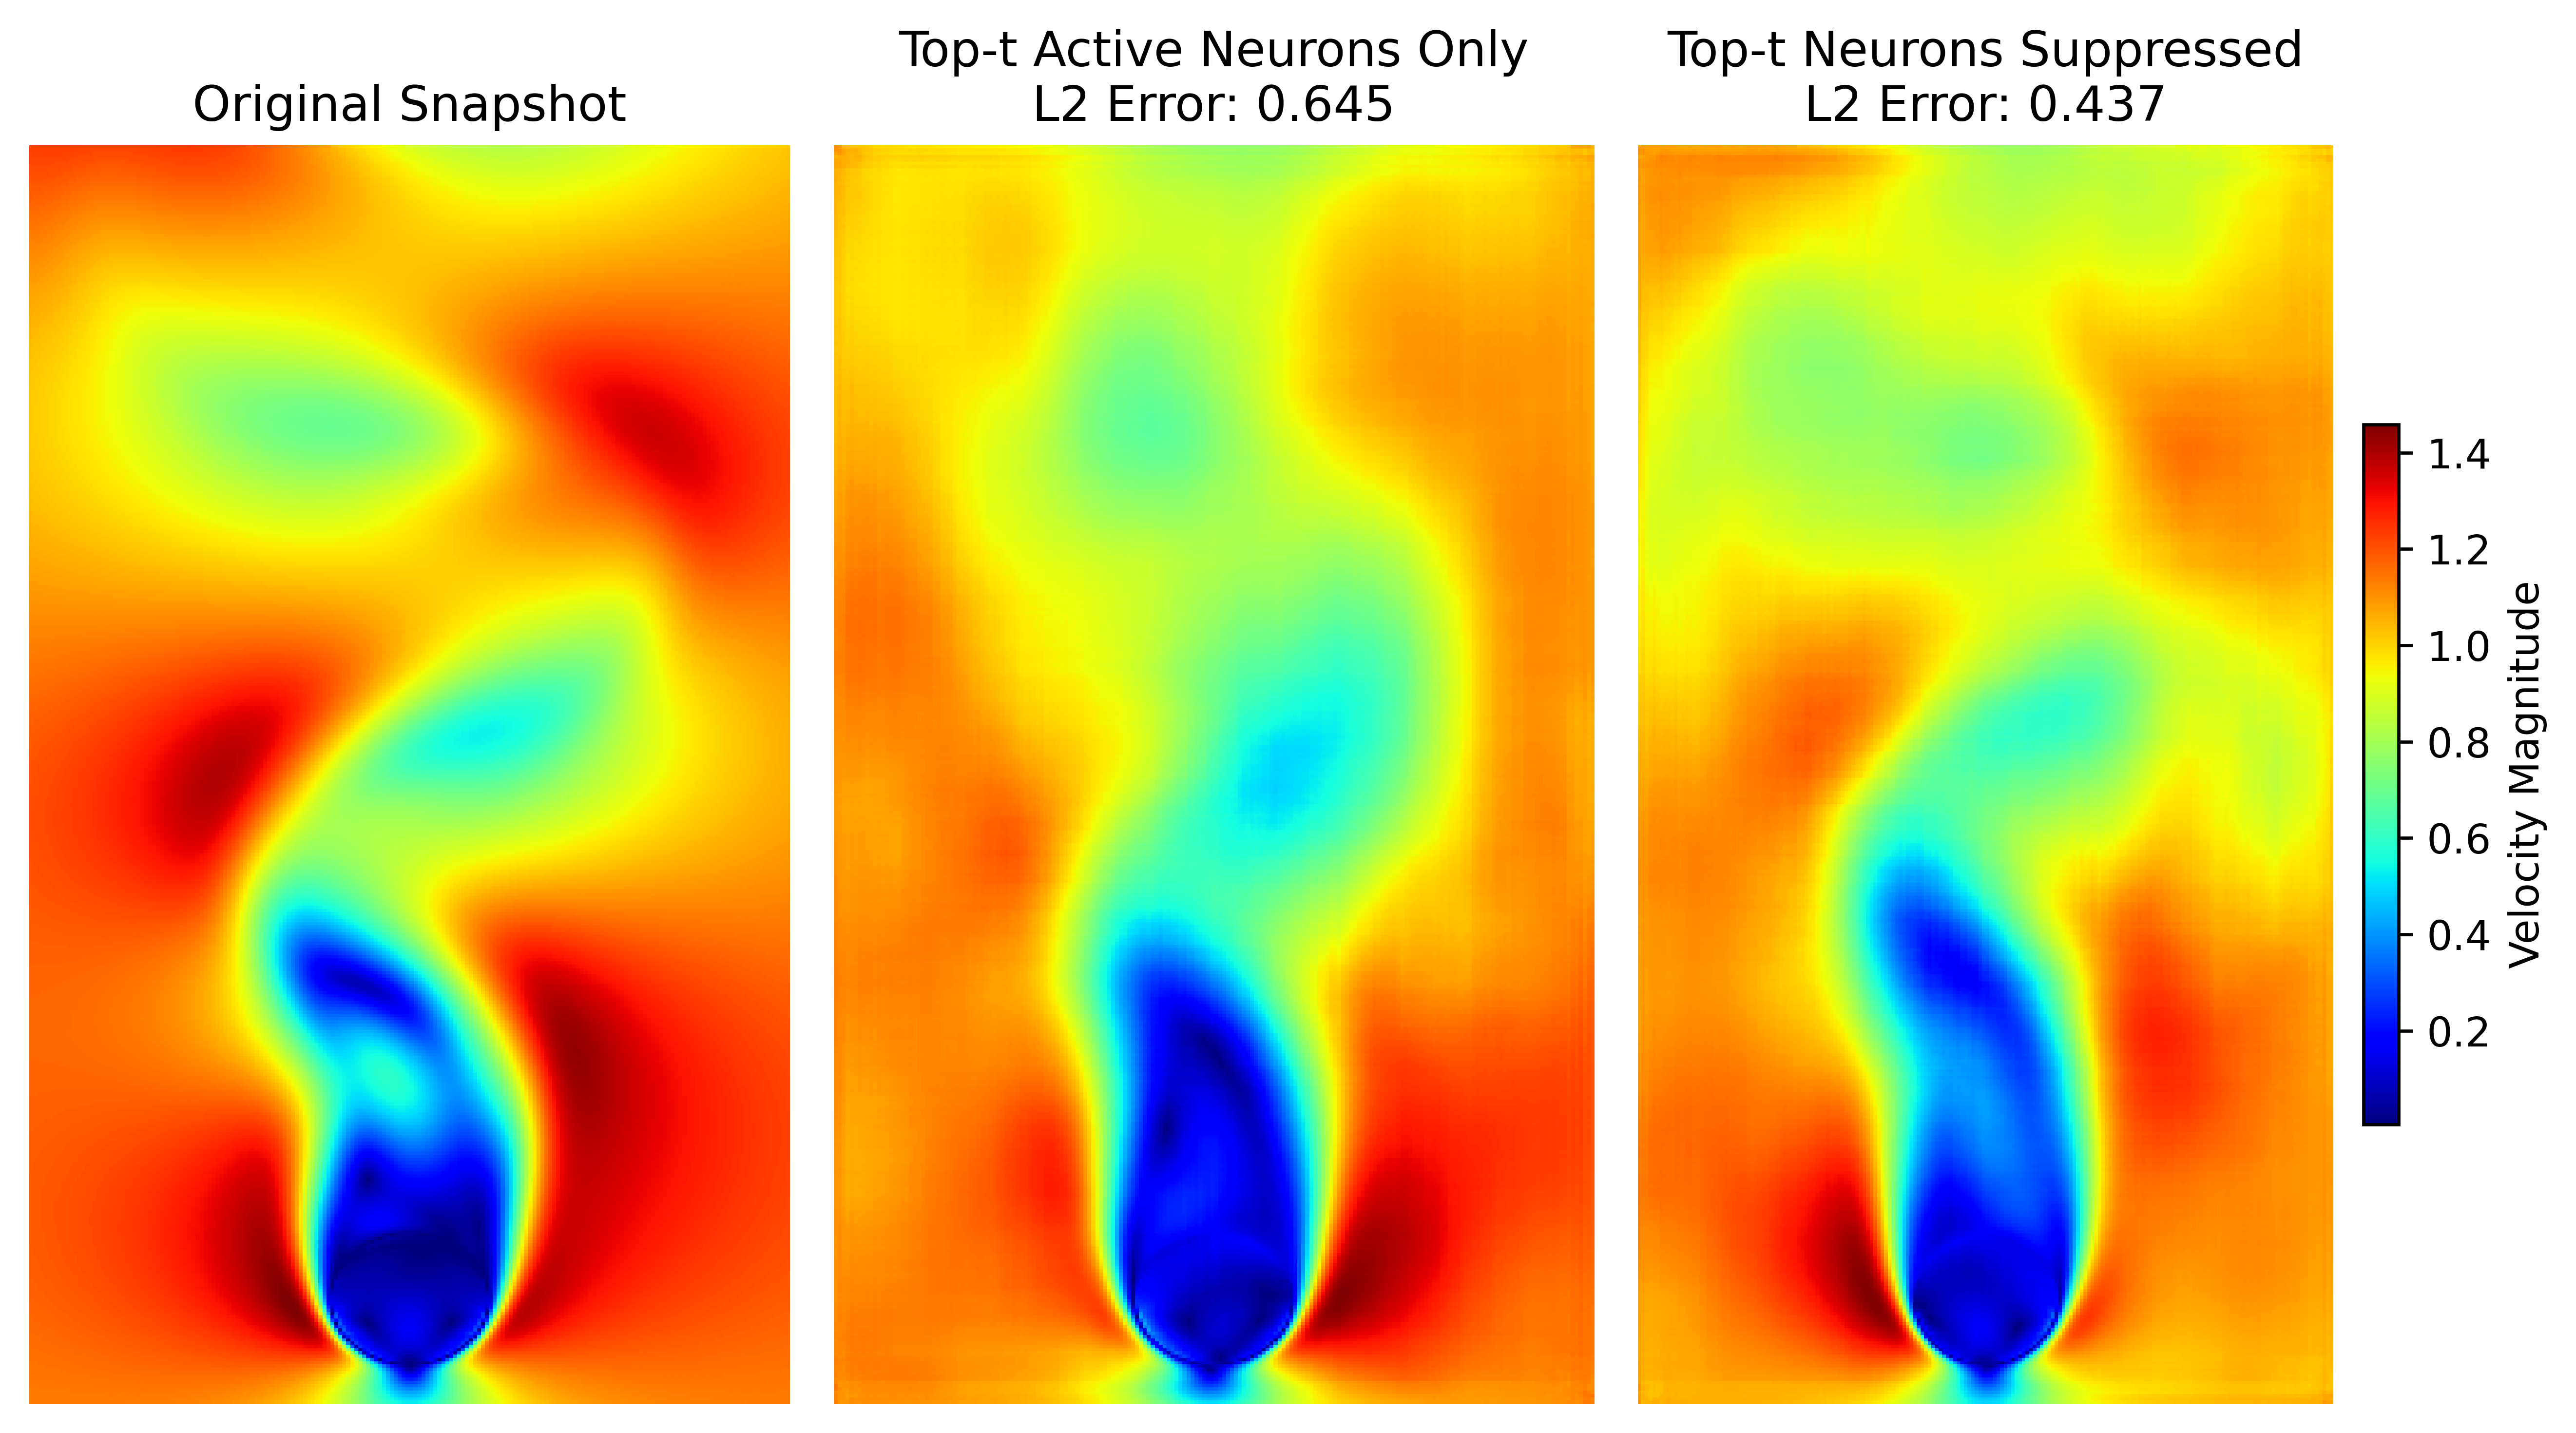

In [ ]:
#Encode Full Dataset to Latent Space
latent_output = encoder_dense.predict(X)  # Shape: (n_samples, 72)
threshold = 0.1  # Define the activation threshold
top_n = 7        # Number of neurons to retain based on desired sparsity

#Count Activation Frequency for Each Neuron
activation_counts = np.sum(np.abs(latent_output) > threshold, axis=0)  # Shape: (72,)

#Select Top-N Most Frequently Activated Neurons
top_n_indices = np.argsort(activation_counts)[-top_n:]

#Choose a Snapshot
snapshot = 67
x_sample = X[snapshot:snapshot+1]  # Keep batch dimension

#Encode Selected Snapshot
z = encoder_dense.predict(x_sample)[0]  # Shape: (72,)

#Masking Based on Top-N Activation Frequency
z_top_active = np.zeros_like(z)
z_top_active[top_n_indices] = z[top_n_indices]

z_suppressed = z.copy()
z_suppressed[top_n_indices] = 0

#Decode
x_rec_top_active = decoder_dense.predict(z_top_active.reshape(1, -1))[0]+UV_reshaped[0]
x_rec_suppressed = decoder_dense.predict(z_suppressed.reshape(1, -1))[0]+UV_reshaped[0]

#Compute Velocity Magnitudes
def compute_mag(field):
    return np.linalg.norm(field, axis=-1)
original=x_sample[0]+UV_reshaped[0]
original_mag = compute_mag(original)
rec_top_mag = compute_mag(x_rec_top_active)
rec_supp_mag = compute_mag(x_rec_suppressed)

#Compute L2 Norm Errors
# L2 error: top-n active neurons only
numerator_top_n = np.sqrt(np.sum((decoder_dense.predict(z_top_active.reshape(1, -1)) - x_sample) ** 2, axis=(1, 2, 3)))
denominator_top_n = np.sqrt(np.sum(x_sample ** 2, axis=(1, 2, 3)))
l2_error_top_n = numerator_top_n / denominator_top_n

# L2 error: top-n suppressed
numerator_suppressed = np.sqrt(np.sum((decoder_dense.predict(z_suppressed.reshape(1, -1)) - x_sample) ** 2, axis=(1, 2, 3)))
denominator_suppressed = np.sqrt(np.sum(x_sample ** 2, axis=(1, 2, 3)))
l2_error_suppressed = numerator_suppressed / denominator_suppressed

#Visualization
plt.figure(figsize=(9, 5))

titles = [
    "Original Snapshot",
    f"Top-t Active Neurons Only\nL2 Error: {l2_error_top_n[0]:.3f}",
    f"Top-t Neurons Suppressed\nL2 Error: {l2_error_suppressed[0]:.3f}"
]
images = [original_mag, rec_top_mag, rec_supp_mag]

for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i+1)
    im = plt.imshow(img, cmap='jet', origin='lower', aspect='auto')
    plt.title(title)
    plt.axis('off')

    # Add colorbar only to the last subplot
    if i == 2:
        cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
        cbar.set_label("Velocity Magnitude", fontsize=10)

plt.tight_layout()
plt.show()

**Top-k Masking based Neuron Analysis (Neuron activation bar charts + segmented analysis)**

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


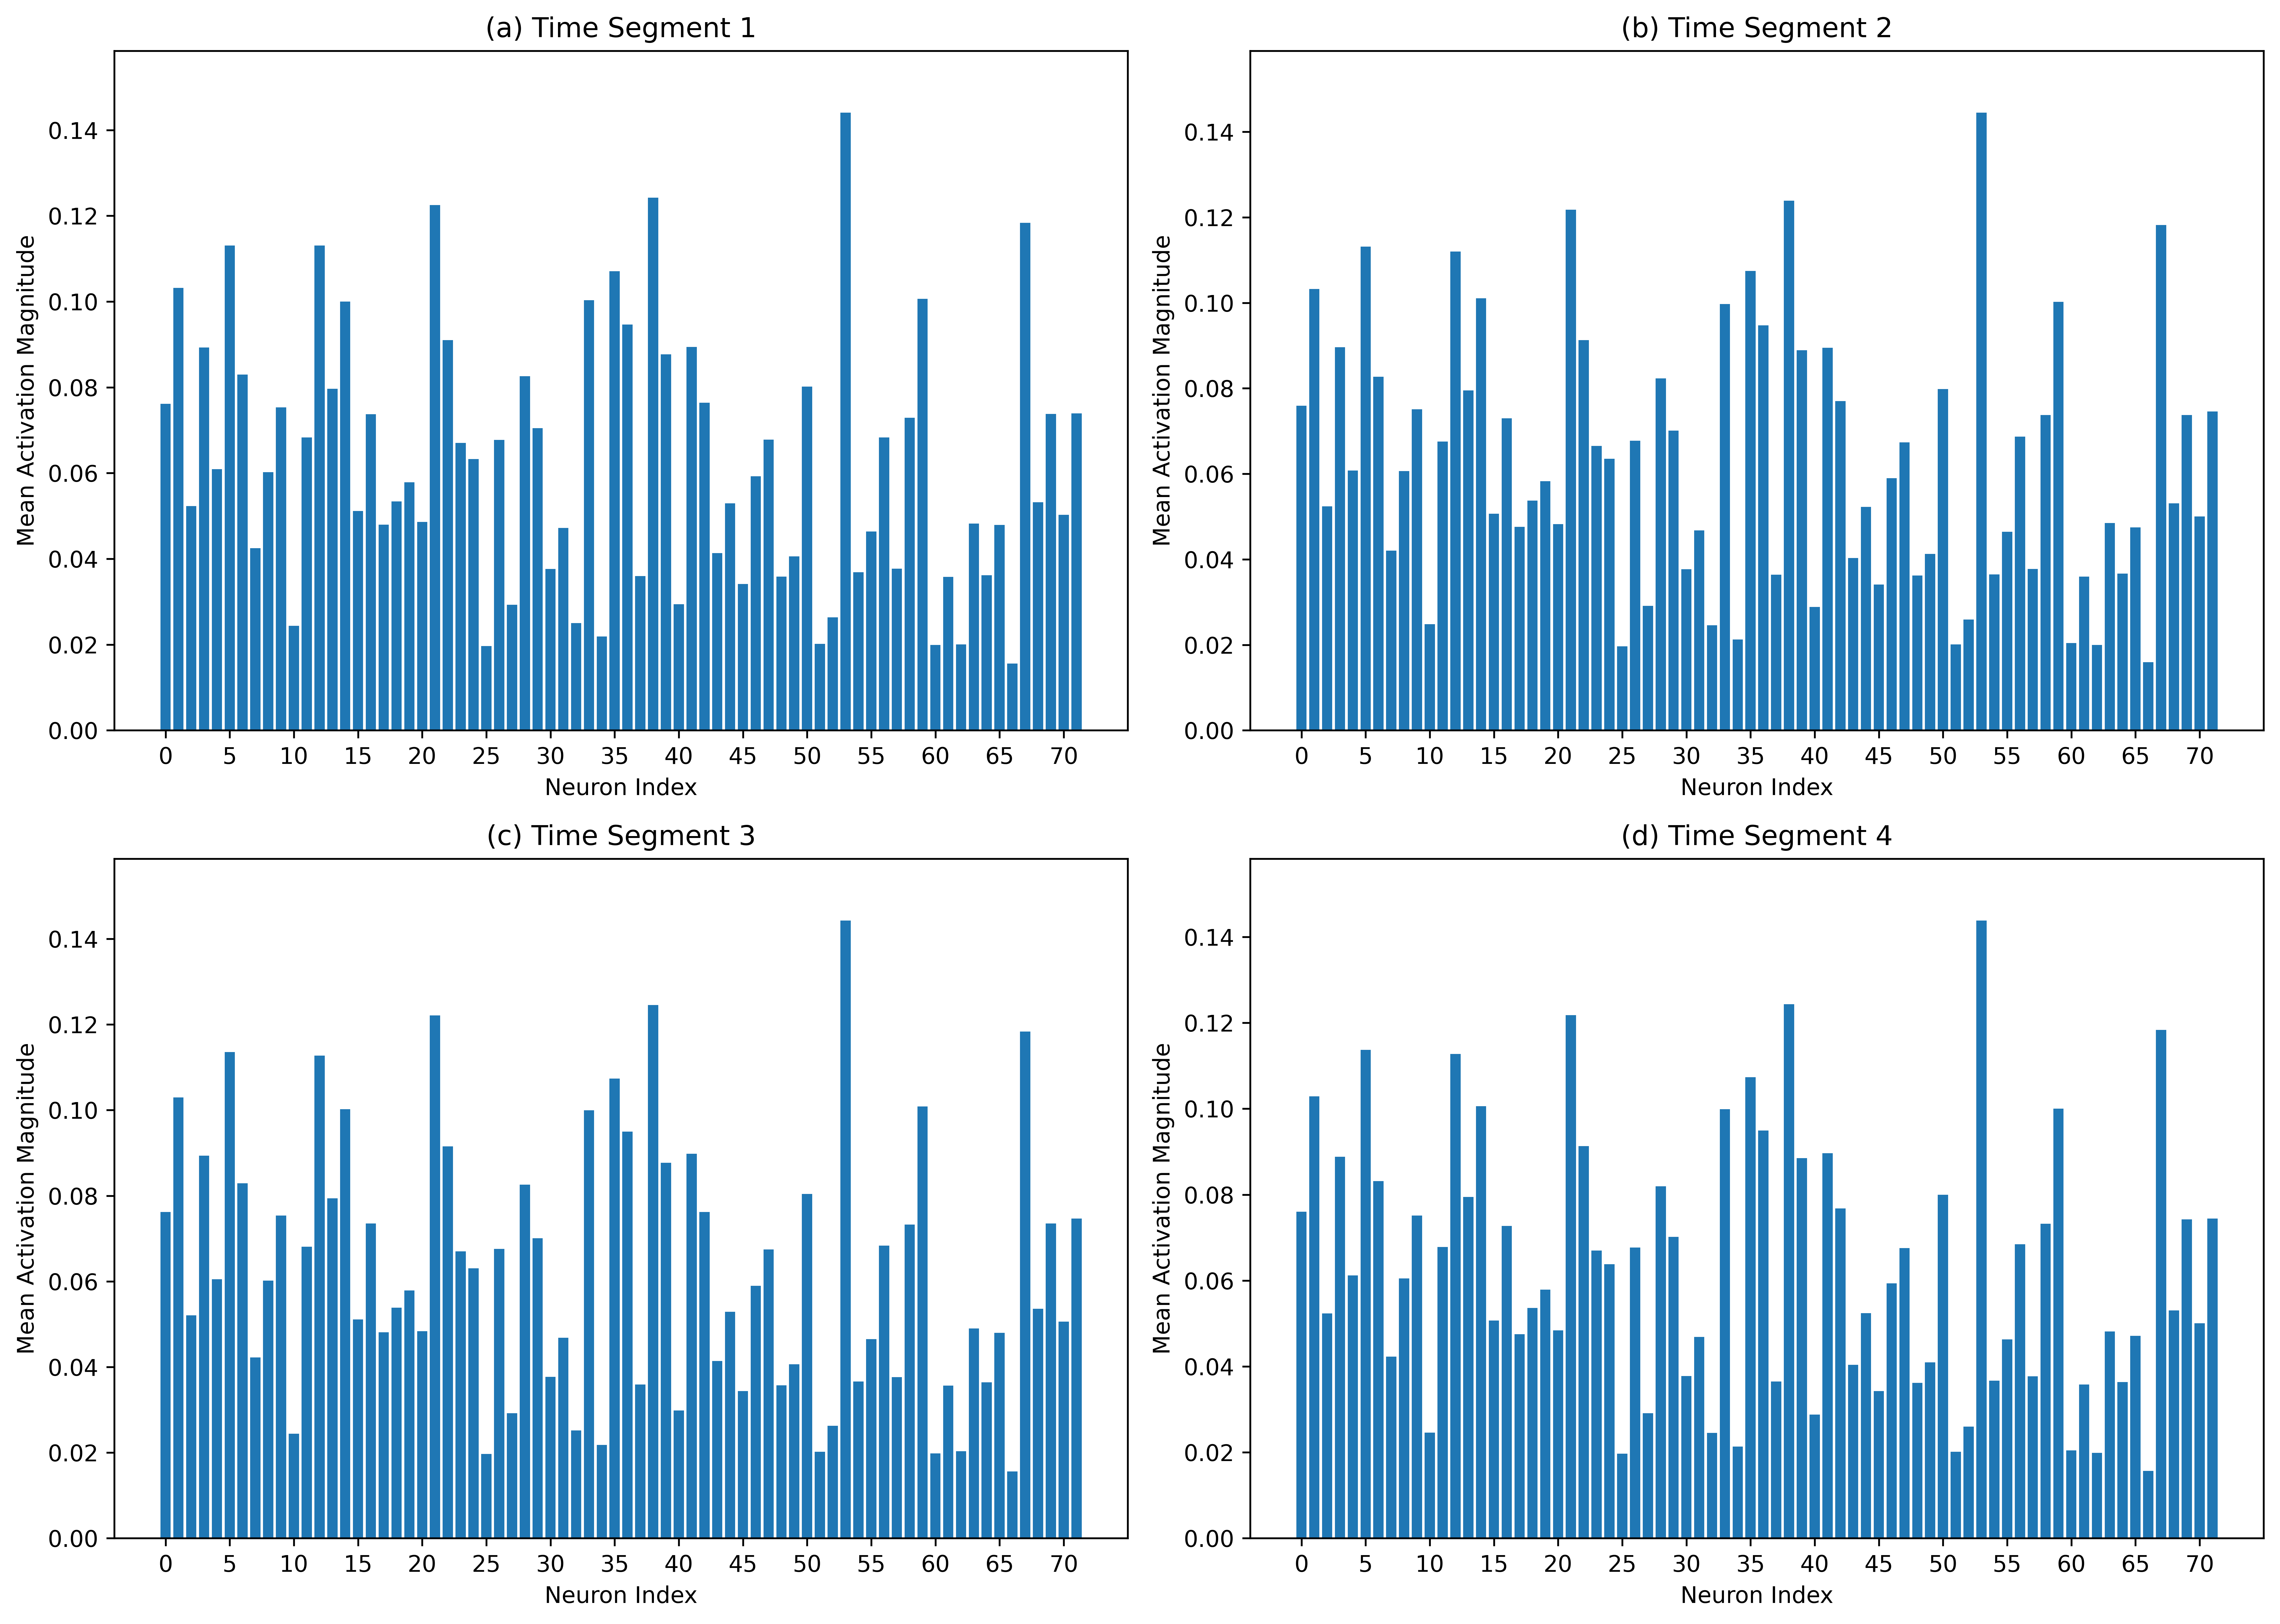

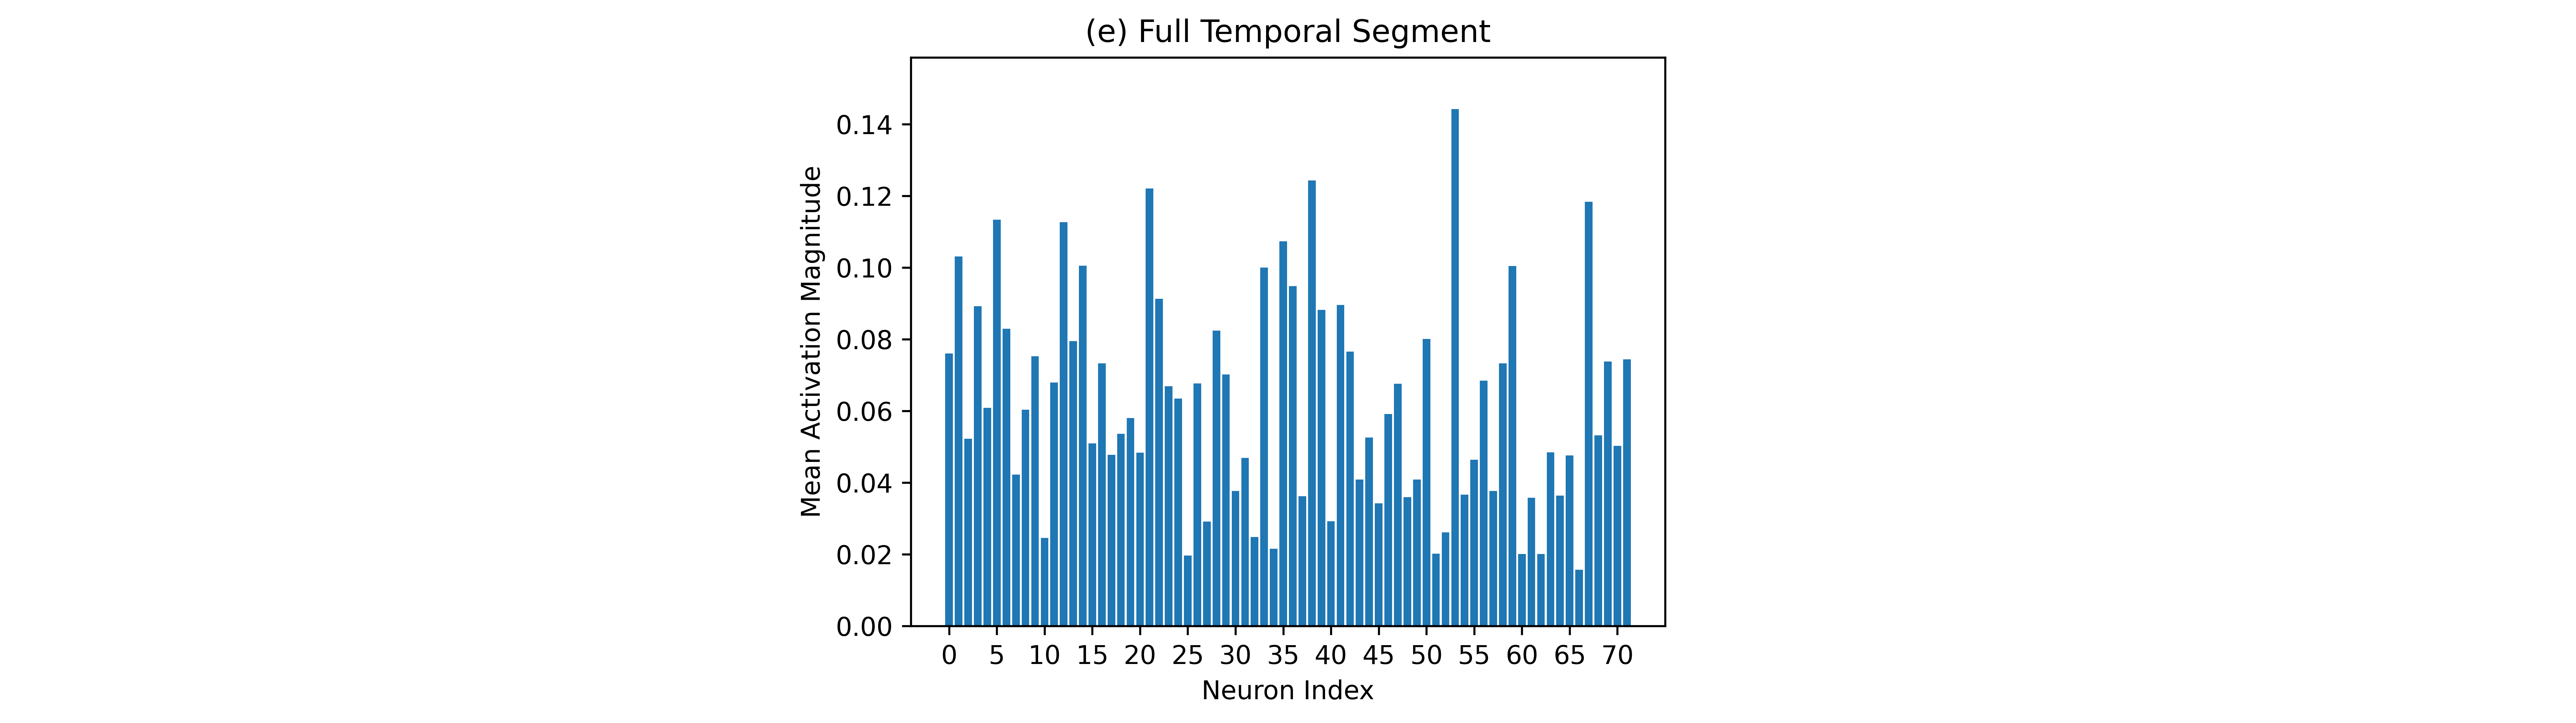

In [ ]:
#Encode full dataset
latent_output = encoder_dense.predict(X)  # shape (n_snapshots, 72)

#Split into 4 temporal segments
segments = np.array_split(latent_output, 4)

#Plot average activation magnitudes for each segment
plt.figure(figsize=(14, 10))
for i, segment in enumerate(segments):
    mean_activation = np.mean(np.abs(segment), axis=0)
    plt.subplot(2, 2, i+1)
    plt.bar(np.arange(len(mean_activation)), mean_activation)
    plt.title(f"({chr(97+i)}) Time Segment {i+1}")
    plt.xlabel("Neuron Index")
    plt.ylabel("Mean Activation Magnitude")
    plt.ylim(0, np.max(mean_activation) * 1.1)
    # Set custom x-axis ticks
    plt.xticks(np.arange(0, len(mean_activation), 5))

plt.tight_layout()
plt.show()

#Plot for full dataset
mean_activation_full = np.mean(np.abs(latent_output), axis=0)
# Use a 1x3 grid and plot in the center (position 2)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].axis('off')  # left empty
axes[2].axis('off')  # right empty
axes[1].bar(np.arange(len(mean_activation_full)), mean_activation_full)
axes[1].set_title("(e) Full Temporal Segment")
axes[1].set_xlabel("Neuron Index")
axes[1].set_ylabel("Mean Activation Magnitude")
axes[1].set_ylim(0, np.max(mean_activation_full) * 1.1)
axes[1].set_xticks(np.arange(0, len(mean_activation_full), 5))
plt.tight_layout()
plt.show()

**Top-k masking based Sparsity–Reconstruction Error Trade-off Curve**

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


  0%|          | 0/19 [00:00<?, ?it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


  5%|▌         | 1/19 [00:24<07:27, 24.84s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 11%|█         | 2/19 [00:48<06:51, 24.19s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 16%|█▌        | 3/19 [01:13<06:29, 24.32s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 21%|██        | 4/19 [01:38<06:08, 24.60s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 26%|██▋       | 5/19 [02:02<05:45, 24.68s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 32%|███▏      | 6/19 [02:27<05:20, 24.63s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 37%|███▋      | 7/19 [02:50<04:50, 24.24s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


 42%|████▏     | 8/19 [03:14<04:25, 24.13s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


 47%|████▋     | 9/19 [03:42<04:11, 25.16s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


 53%|█████▎    | 10/19 [04:08<03:48, 25.40s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


 58%|█████▊    | 11/19 [04:31<03:19, 24.92s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 63%|██████▎   | 12/19 [04:56<02:52, 24.65s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 68%|██████▊   | 13/19 [05:20<02:26, 24.49s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 74%|███████▎  | 14/19 [05:46<02:04, 24.99s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 79%|███████▉  | 15/19 [06:10<01:38, 24.72s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 84%|████████▍ | 16/19 [06:34<01:13, 24.53s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 89%|████████▉ | 17/19 [06:58<00:49, 24.52s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 95%|█████████▍| 18/19 [07:22<00:24, 24.37s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


100%|██████████| 19/19 [07:47<00:00, 24.59s/it]


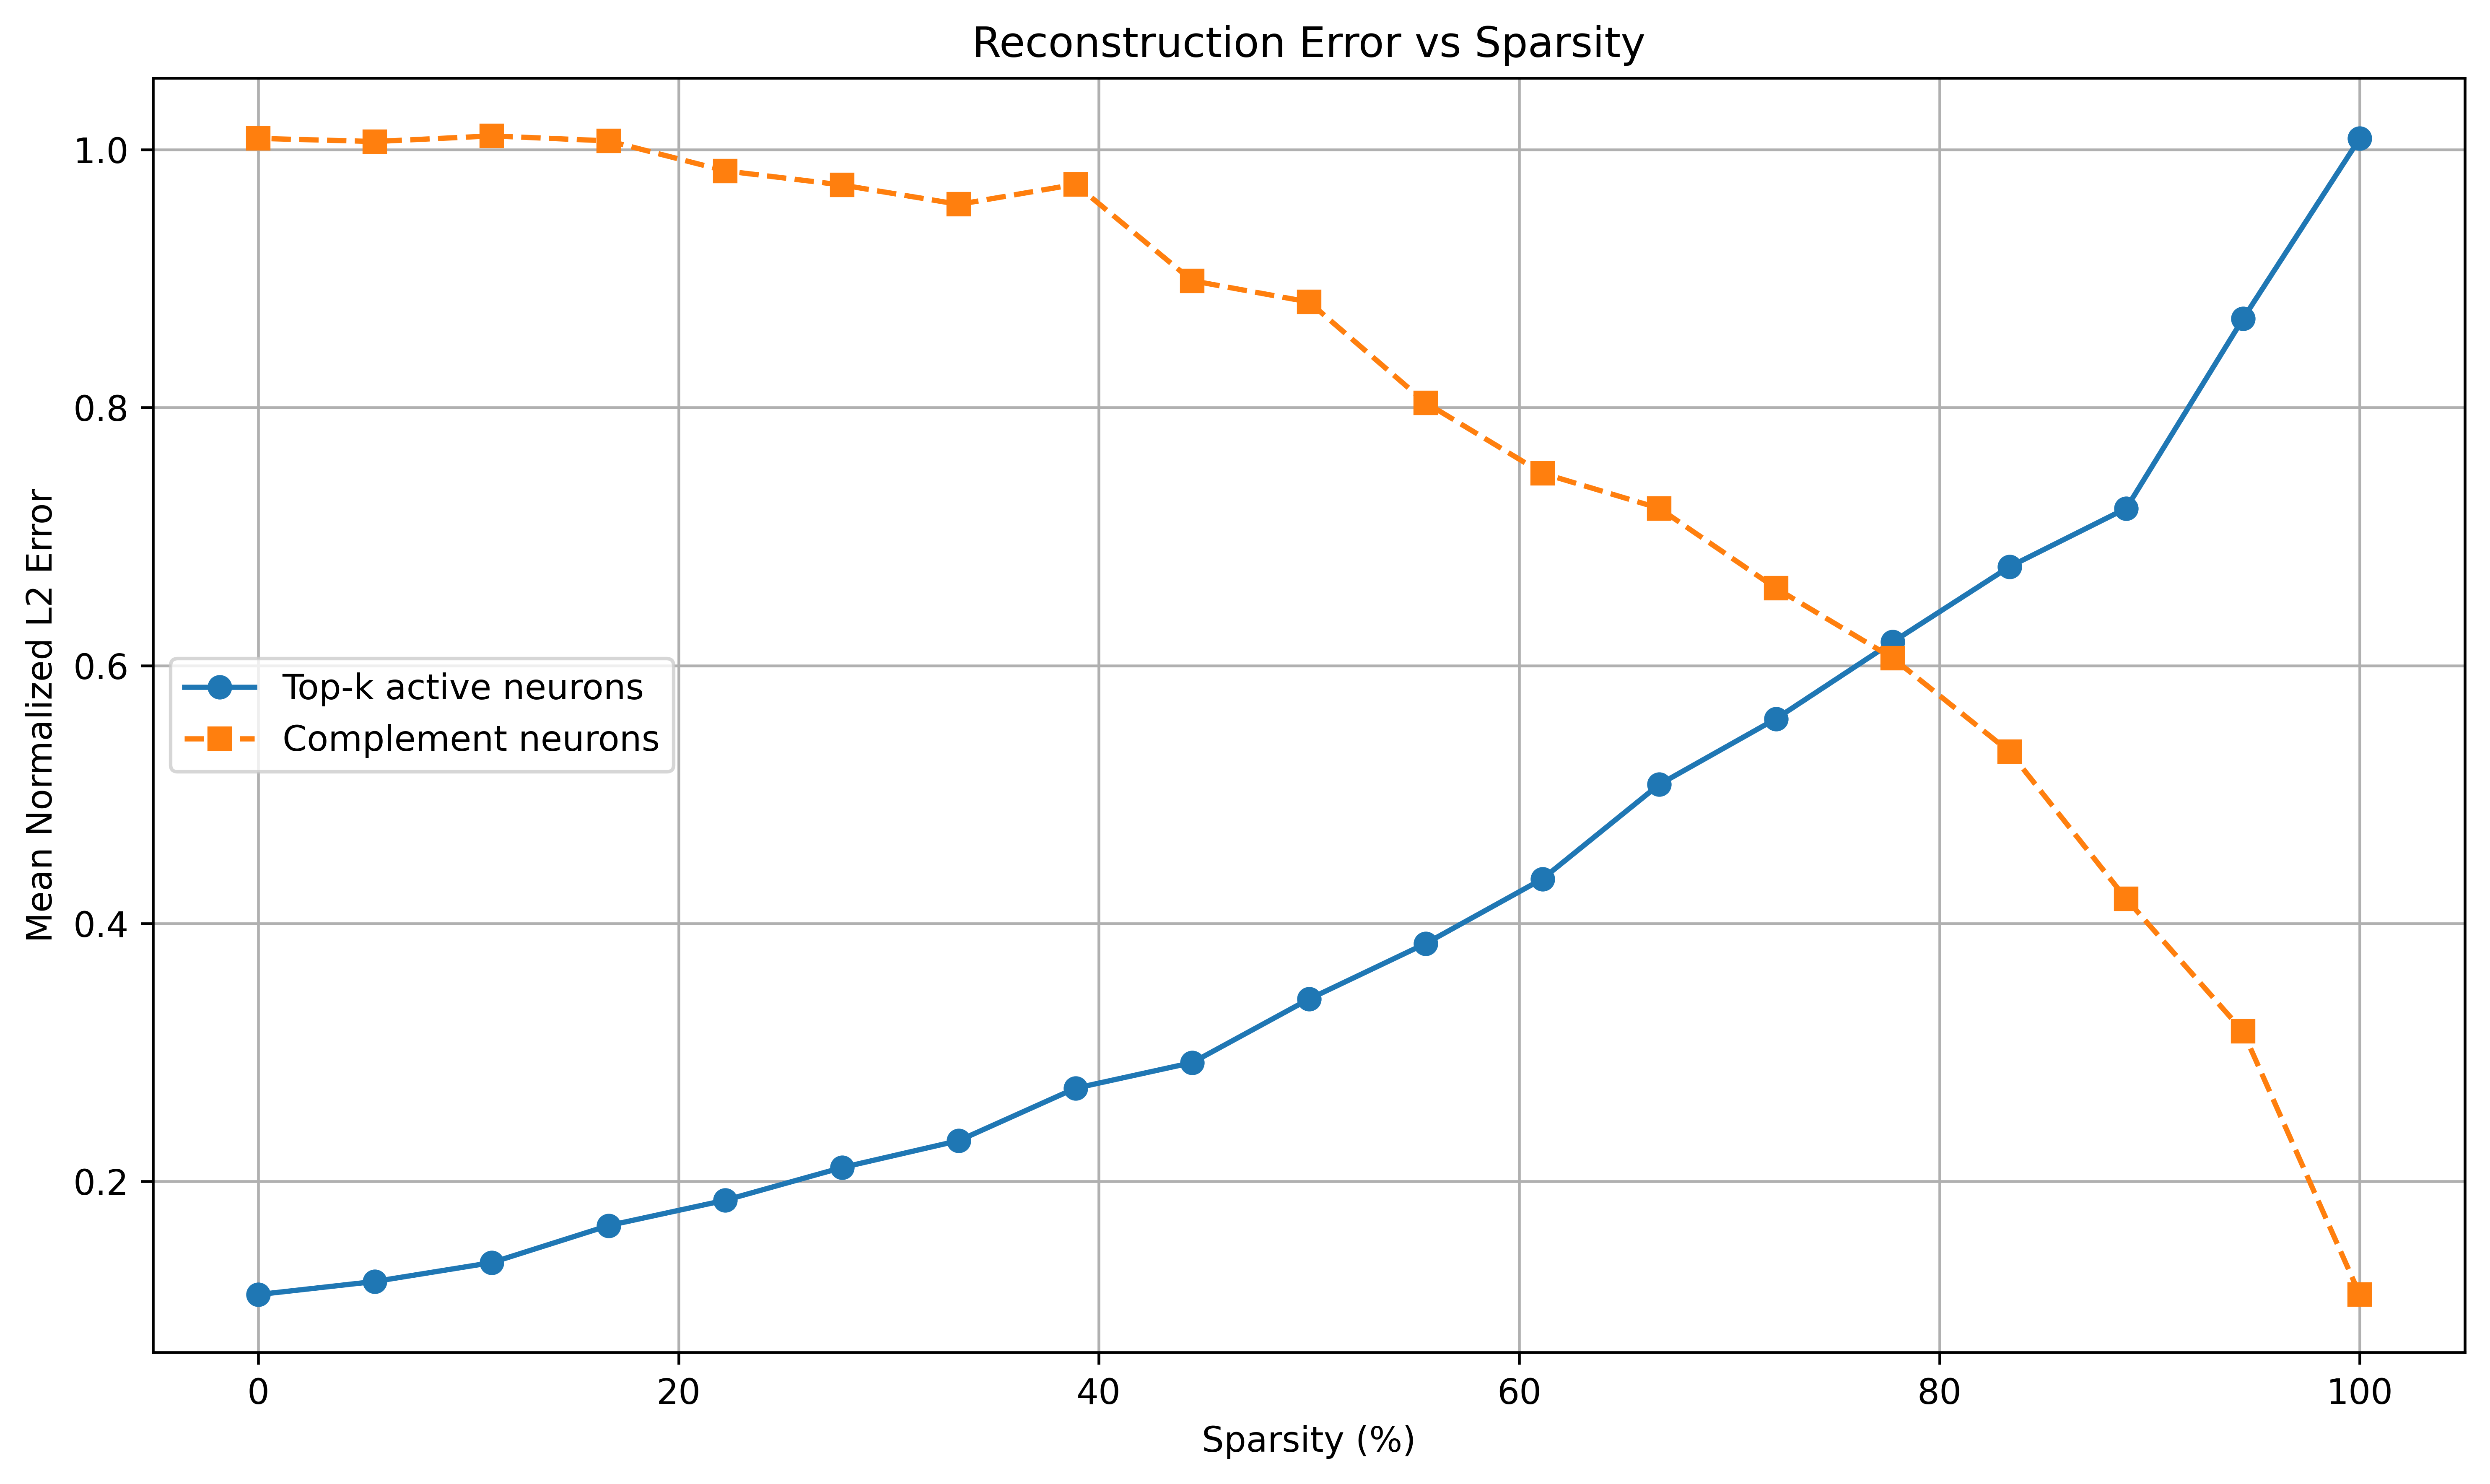

In [ ]:
#Compute mean activation magnitude for each neuron
latent_output = encoder_dense.predict(X)  # shape: (num_samples, 72)
mean_magnitude_full = np.mean(np.abs(latent_output), axis=0)  # shape: (72,)

# Prepare for loop
latent_dim = latent_output.shape[1]  # 72
step = 4
sparsity_list = []
top_k_errors = []
suppressed_k_errors = []

#Loop over k in steps of 4
for k in tqdm(range(0, latent_dim + 1, step)):
    #Get top-k neurons by mean activation magnitude
    top_k_indices = np.argsort(-mean_magnitude_full)[:k]
    complement_indices = np.setdiff1d(np.arange(latent_dim), top_k_indices)

    #Encode all snapshots
    Z_all = encoder_dense.predict(X)

    # Masked latent vectors (Top-k active neurons only)
    Z_top_k = np.zeros_like(Z_all)
    Z_top_k[:, top_k_indices] = Z_all[:, top_k_indices]

    # Masked latent vectors (Complement neurons only)
    Z_suppressed = np.zeros_like(Z_all)
    Z_suppressed[:, complement_indices] = Z_all[:, complement_indices]

    #Decode and compute normalized L2 error (Top-k)
    X_rec_top_k = decoder_dense.predict(Z_top_k)
    numerator = np.sqrt(np.sum((X_rec_top_k - X) ** 2, axis=(1, 2, 3)))
    denominator = np.sqrt(np.sum(X ** 2, axis=(1, 2, 3)))
    l2_error_top_k = numerator / denominator
    mean_error_top_k = np.mean(l2_error_top_k)

    #Decode and compute normalized L2 error (Suppressed-k)
    X_rec_suppressed = decoder_dense.predict(Z_suppressed)
    numerator = np.sqrt(np.sum((X_rec_suppressed - X) ** 2, axis=(1, 2, 3)))
    denominator = np.sqrt(np.sum(X ** 2, axis=(1, 2, 3)))
    l2_error_suppressed = numerator / denominator
    mean_error_suppressed = np.mean(l2_error_suppressed)

    #Sparsity percentage
    sparsity_percent = 100 * (1 - k / latent_dim)

    #Store results
    sparsity_list.append(sparsity_percent)
    top_k_errors.append(mean_error_top_k)
    suppressed_k_errors.append(mean_error_suppressed)

#Plot the results
plt.figure(figsize=(10,6))
plt.plot(sparsity_list, top_k_errors, 'o-', label='Top-k active neurons')
plt.plot(sparsity_list, suppressed_k_errors, 's--', label='Complement neurons')
plt.xlabel('Sparsity (%)')
plt.ylabel('Mean Normalized L2 Error')
plt.title('Reconstruction Error vs Sparsity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Top-k masking based Feature Extraction**

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


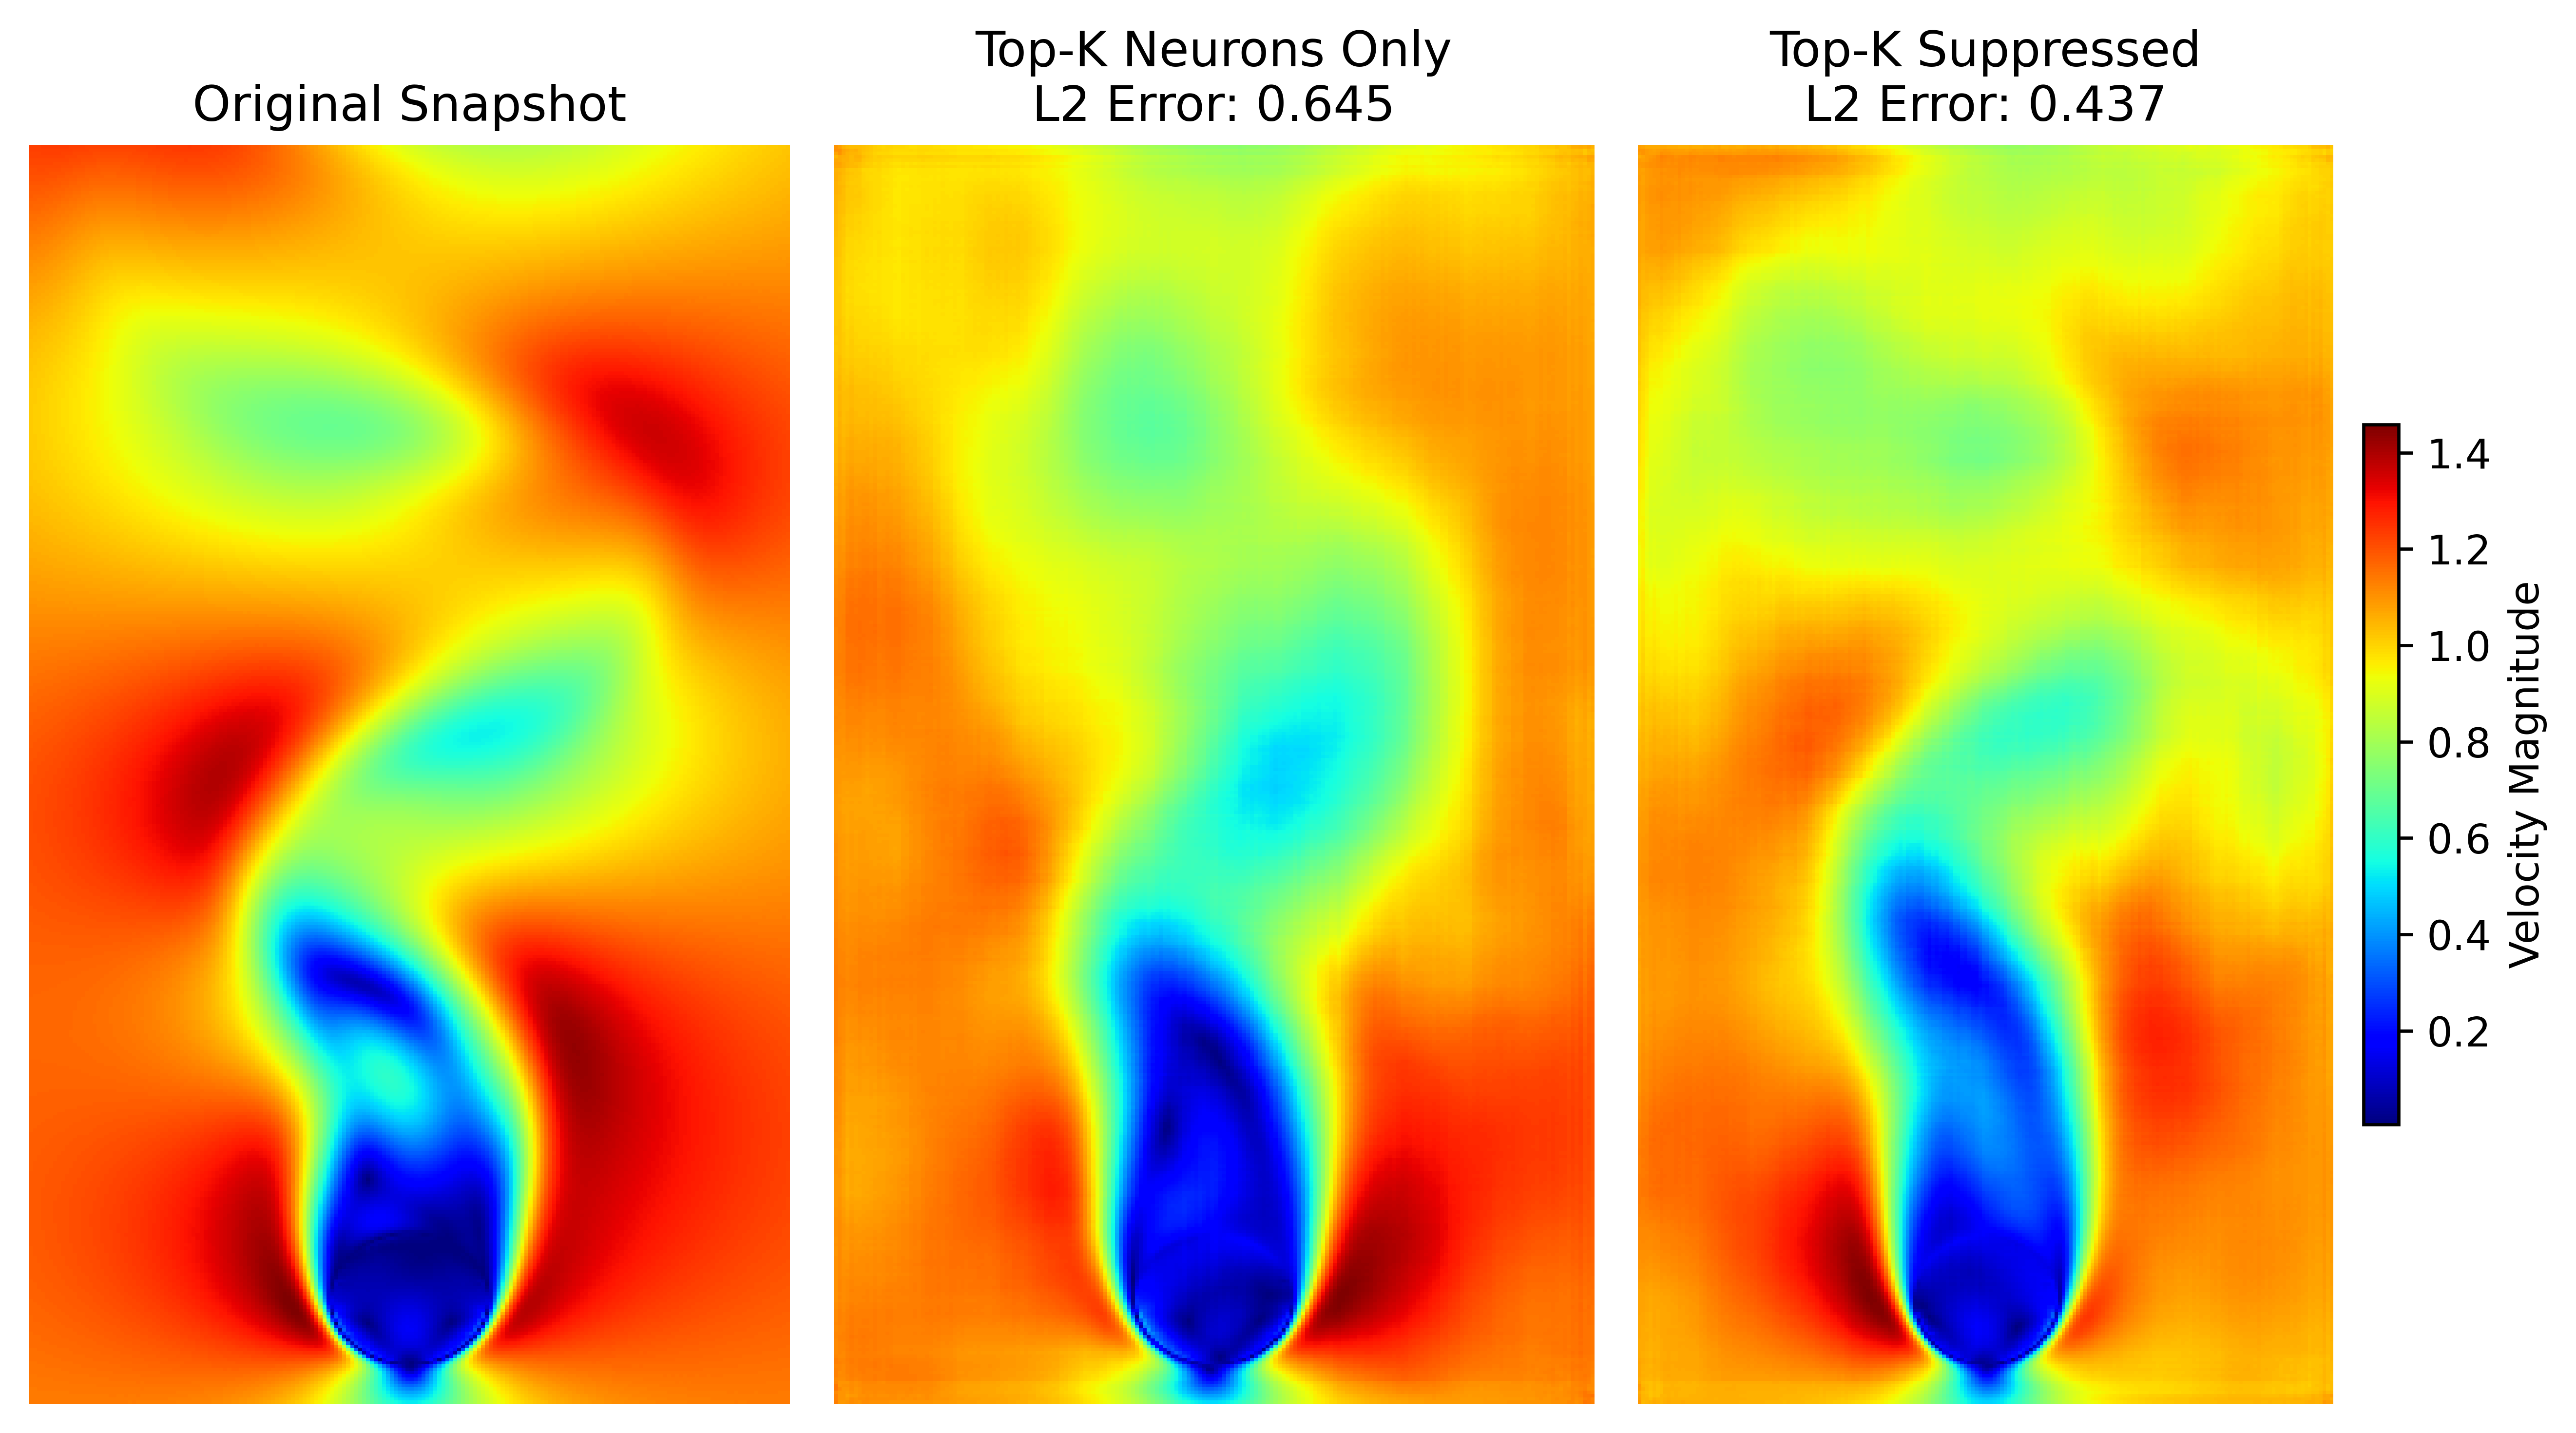

In [ ]:
#Encode Full Dataset and Get Top-K Neurons
latent_output = encoder_dense.predict(X)  # Shape: (n_samples, 72)
top_k =7   # Number of neurons to retain based on desired sparsity

# Compute mean absolute activation across dataset
mean_magnitude = np.mean(np.abs(latent_output), axis=0)
top_k_indices = np.argsort(mean_magnitude)[-top_k:]  # Top-K neuron indices

#Choose a Snapshot
snapshot = 67
x_sample = X[snapshot:snapshot+1]  # Keep batch dimension (1, 384, 192, 2)

#Encode the Snapshot
z = encoder_dense.predict(x_sample)[0]  # Shape: (72,)

#Mask all but Top-K Neurons
z_top_k_only = np.zeros_like(z)
z_top_k_only[top_k_indices] = z[top_k_indices]

#Decode Using Only Top-K Neurons
x_rec_top_k = decoder_dense.predict(z_top_k_only.reshape(1, -1))[0]+UV_reshaped[0]

#Suppress Top-K Neurons and Use the Rest
z_rest_only = z.copy()
z_rest_only[top_k_indices] = 0

x_rec_rest = decoder_dense.predict(z_rest_only.reshape(1, -1))[0]+UV_reshaped[0]

#Original Snapshot (for Comparison)
original = x_sample[0]+UV_reshaped[0]  # Shape: (384, 192, 2)

# Compute Velocity Magnitude
def compute_mag(frame):
    return np.linalg.norm(frame, axis=-1)

original_mag = compute_mag(original)
rec_top_k_mag = compute_mag(x_rec_top_k)
rec_rest_mag = compute_mag(x_rec_rest)

#l2 norm error top k
numerator_top_k = np.sqrt(np.sum((decoder_dense.predict(z_top_k_only.reshape(1, -1)) - x_sample) ** 2, axis=(1, 2, 3)))
denominator_top_k = np.sqrt(np.sum(x_sample ** 2, axis=(1, 2, 3)))
l2_error_top_k= numerator_top_k / denominator_top_k

#l2 norm error top k supress
numerator_top_k_supressed = np.sqrt(np.sum((decoder_dense.predict(z_rest_only.reshape(1, -1)) - x_sample) ** 2, axis=(1, 2, 3)))
denominator_top_k_suprssed = np.sqrt(np.sum(x_sample ** 2, axis=(1, 2, 3)))
l2_error_suppressed_top_k= numerator_top_k_supressed / denominator_top_k_suprssed

#Plot
plt.figure(figsize=(9, 5))

titles = [
    "Original Snapshot",
    f"Top-K Neurons Only\nL2 Error: {l2_error_top_k[0]:.3f}",
    f"Top-K Suppressed\nL2 Error: {l2_error_suppressed_top_k[0]:.3f}"
]
data = [original_mag, rec_top_k_mag, rec_rest_mag]

for i, (img, title) in enumerate(zip(data, titles)):
    plt.subplot(1, 3, i+1)
    im = plt.imshow(img, cmap='jet', origin='lower', aspect='auto')
    plt.title(title)
    plt.axis('off')

    # Add colorbar to the last subplot only
    if i == 2:
        cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
        cbar.set_label("Velocity Magnitude", fontsize=10)

plt.tight_layout()
plt.show()